Mimicing qiskit VQE's structure but running on scipy. Takes a very long time to optimize. 

In [1]:
%run SetUp.ipynb

from scipy.optimize import minimize

In [2]:
from matplotlib import pyplot as plt

# VQE with Scipy 

In [3]:

# Generate Fake Vacuum
# version that generates [[1,0,...]] and has dimension issues:  
#fake_vac = ft.reduce(sp.sparse.kron, [[1,0]]* nq)

#fake_vac = sp.sparse.csr_array(np.ndarray.flatten(ft.reduce(sp.sparse.kron, [[1,0]]* nq).toarray()))
fake_vac =  sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[1.,0.]]* nq).toarray()).transpose()

In [4]:
#working on this
# Layers of VQE

def single_qubit_mat(angle):
    return ft.reduce(sp.sparse.kron, [ry(angle)]* nq)

def two_qubit_mat(zy_ang,yz_ang):
    n_sets = int(nq/2)
    mat = sp.sparse.identity(2**nq)
    zy_ang,yz_ang = zy_ang/2,yz_ang/2 # to match with qiskit's angle conventions

    for ii in range(n_sets):
        b,c = (2*ii+1)%nq,(2*ii+2)%nq

        mat @= sp.sparse.linalg.expm(-1j * zy_ang * pad_op(b,nq,z) @ pad_op(c,nq,y))
        mat @= sp.sparse.linalg.expm(-1j * yz_ang * pad_op(b,nq,y) @ pad_op(c,nq,z))
        
    for i in range(n_sets):
        a,b = 2*i,(2*i+1)%nq

        mat @= sp.sparse.linalg.expm(-1j * zy_ang * pad_op(a,nq,z) @ pad_op(b,nq,y))
        mat @= sp.sparse.linalg.expm(-1j * yz_ang * pad_op(a,nq,y) @ pad_op(b,nq,z))


    return mat

def three_qubit_mat(angle):
    n_sets = int(nq/3)
    mat = sp.sparse.identity(2**nq)
    angle = angle/2

    for mmm in range(n_sets):
        cc,dd,ee = (3*mmm+2)%nq,(3*mmm+3)%nq,(3*mmm+4)%nq
        mat @= sp.sparse.linalg.expm(-1j * angle * pad_op(cc,nq,z) @ pad_op(dd,nq,y) @ pad_op(ee,nq,z))

    for mm in range(n_sets):
        bb,cc,dd = (3*mm+1)%nq,(3*mm+2)%nq,(3*mm+3)%nq
        mat @= sp.sparse.linalg.expm(-1j * angle * pad_op(bb,nq,z) @ pad_op(cc,nq,y) @ pad_op(dd,nq,z))

        
    for m in range(n_sets):
        aa,bb,cc = (3*m)%nq,(3*m+1)%nq,(3*m+2)%nq
        mat @= sp.sparse.linalg.expm(-1j * angle * pad_op(aa,nq,z) @ pad_op(bb,nq,y) @ pad_op(cc,nq,z))
    

    return mat


In [5]:

def vqe_form(angles):
    it = iter(angles)

    '''one qubit gates layer'''
    one_qubit_angle = next(it)
    mat1 = single_qubit_mat(one_qubit_angle)

    '''two qubit gates layer'''
    # ZY two qubit gates have the same angle; YZ two qubit gates have the same angle;
    ZY_angle = next(it)
    YZ_angle = next(it)
    mat2 = two_qubit_mat(ZY_angle,YZ_angle)
        
    ''' three qubit gates layer '''
    tri_angle = next(it)
    mat3 = three_qubit_mat(tri_angle)

    '''two qubit gates layer'''
    ZY_angle = next(it)
    YZ_angle = next(it)
    mat4 = two_qubit_mat(ZY_angle,YZ_angle)
    
    # think about what order this operates in. Want to do the single qubit layer first
    return mat4 @ mat3 @ mat2 @ mat1

In [6]:
# Generate a state from a set of angles
# Calculate full Hamiltonian expectation value for this state 
# Want to minimize this expectation value

# Hf = sp.sparse.bsr_matrix(Hfull(nq,m,g).to_matrix())
Hf = sp.sparse.csr_matrix(np.real(Hfull(nq,m,g).to_matrix()))

def H_exp(angles):
    
    state = vqe_form(angles).dot(fake_vac)
    
    #val = np.reshape(np.asarray(state.conjugate()),-1) @ Hf @ np.reshape(np.asarray(state),-1)
    val = state.getH() @ Hf @ state
    
    return np.real(val.toarray()[0][0])

In [7]:
num_params = 6

initial_point = np.random.rand(num_params)

H_exp(initial_point)

/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


7.369507373052054

#### nelder-mead

In [31]:
res = minimize(H_exp, initial_point, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 5.311450
         Iterations: 421
         Function evaluations: 692


In [32]:
print(res.x)

[ 1.57377553  0.85553474  0.85553475  1.47014261 -0.10229434 -0.10229433]


#### powell

In [10]:
res2 = minimize(H_exp, initial_point, method='powell',
               options={'disp': True})

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_17922/3822391983.py:1: OptimizeWarning: Unknown solver options: xatol
  res2 = minimize(H_exp, initial_point, method='powell',


Optimization terminated successfully.
         Current function value: 5.311535
         Iterations: 11
         Function evaluations: 671


In [71]:
print(res2.x)

[ 1.58163597  2.05020712 -0.97838434  0.83319393 -0.17114888  1.0119219 ]


#### BFGS

In [11]:
res3 = minimize(H_exp, initial_point, method='BFGS',
               options={'disp': True})

Optimization terminated successfully.
         Current function value: -0.690046
         Iterations: 52
         Function evaluations: 441
         Gradient evaluations: 63


In [13]:
print(res3.x)

[-0.10081331 -0.01268476  3.1289      2.842224   -0.07051683 -0.07051883]


# Test

In [33]:
scipy_angles = [-0.10081331, -0.01268476,  3.1289,      2.842224,   -0.07051683, -0.07051883]
scipy_results = np.reshape(vqe_form(scipy_angles).dot(fake_vac).toarray(),-1)

In [34]:
'''qiskit_angles = np.array([-0.22747522, -0.00897031,  0.5817404 ,  0.03811703, -0.04602667,
       -0.00888931,  2.54297371])'''
# qiskit_angles = np.array([ 0.0310549 ,  0.08593939, -0.0328307 , -0.18265392,  2.99830422,
#       -0.02271861])
# qiskit_results = np.reshape(vqe_form(qiskit_angles).dot(fake_vac).toarray(),-1)

'qiskit_angles = np.array([-0.22747522, -0.00897031,  0.5817404 ,  0.03811703, -0.04602667,\n       -0.00888931,  2.54297371])'

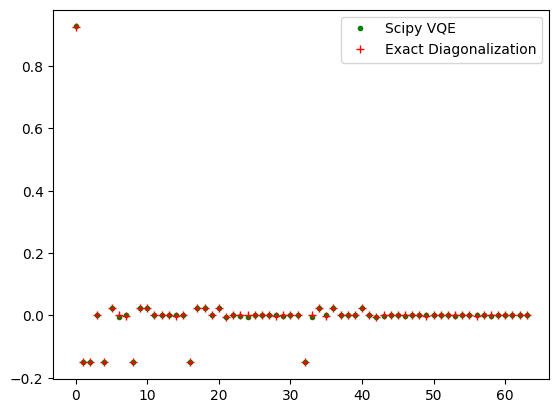

In [35]:
plt.plot(list(range(2**nq)), -scipy_results,'g.',label = 'Scipy VQE')
# plt.plot(list(range(2**nq)), -qiskit_results,'b.',label = 'Qiskit VQE')
plt.plot(list(range(2**nq)), mathematica_result_6_SU2,'r+',label = 'Exact Diagonalization')
plt.legend()